# Heads-up

In this notebook, we keep exploring
the greedy strategy. 

Differently, we give the model more
information regarding not only a node's
first order but also second order, third
order (or more) out neighbors.

Similarly, the model is given the first
order out neighbor with smallest weight
as the "ground truth"

# Some take-aways

Seems that the model has learned to be not greedy
on some graphs; since when a pure greedy strategy
coundn't even find a path, i.e., the algorithm gets
stuck in a cycle, the neural network is able to be
not so greedy and still find a path towards the goal

In [152]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import generate_low_degree_g, plot_g

In [177]:
G = generate_low_degree_g()
print(G.number_of_nodes())
print(G.number_of_edges())

20
61


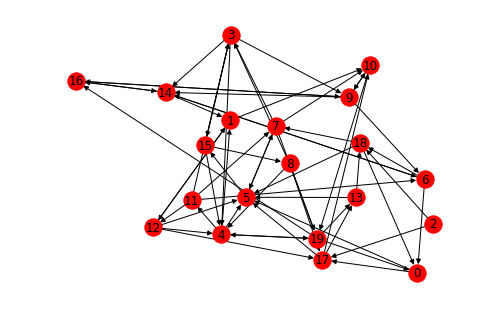

In [178]:
plot_g(G)

In [179]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

4

In [180]:
def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones((max_out_degree, (max_out_degree + 1)))

        for idx, out_edge in enumerate(G.out_edges(node)):
            out_neighbor = out_edge[1]
            init_weight_vec[idx][0] = G.get_edge_data(node, out_neighbor)['weight']
            
            for second_idx, second_order_out_edge in enumerate(G.out_edges(out_neighbor), start=1):
                init_weight_vec[idx][second_idx] = G.get_edge_data(out_neighbor, second_order_out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])

        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)
print(features.shape)
print(labels.shape)

(20, 4, 5)
(20,)


In [182]:
def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def augment_dataset(X, y=None, augmentation_1=100, augmentation_2=200):
    
    X_aug, y_aug = [], []
    indices_1 = np.arange(max_out_degree)
    indices_2 = list(range(1, 1 + max_out_degree))
    
    for _, x in enumerate(X):
        for _ in range(augmentation_1):
            np.random.shuffle(indices_1)
            
            feature_1 = x[indices_1]
            
            for _ in range(augmentation_2):

                for f_2_idx, feature_2 in enumerate(feature_1):

                    np.random.shuffle(indices_2)
                    feature_1[f_2_idx] = feature_2[[0] + indices_2]
                    X_aug.append(feature_1)
                    y_aug.append(one_hot_encode(np.argmin(feature_1, axis=0)[0]))

            
    return np.array(X_aug), np.array(y_aug)

X_aug, y_aug = augment_dataset(features, labels)
print(X_aug.shape)
print(y_aug.shape)
print(X_aug[-1])
print(y_aug[-1])

(1600000, 4, 5)
(1600000, 4)
[[ 0.05719178  0.81145912  0.62126454  1.          1.        ]
 [ 0.15902553  0.94033102  1.          1.          0.06014211]
 [ 0.78387317  0.80233105  1.          1.          0.44309984]
 [ 0.27670891  0.08026971  0.10369411  0.50007518  0.75346993]]
[ 1.  0.  0.  0.]


In [183]:
from sklearn.model_selection import train_test_split
import calendar
import time

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, train_size=0.8, test_size=0.2, \
                                                    random_state=calendar.timegm(time.gmtime()))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1280000, 4, 5)
(1280000, 4)
(320000, 4, 5)
(320000, 4)


In [184]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [185]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    data = mx.sym.flatten(data=data)
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [189]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=2)  # train for at most 10 dataset passes

In [ ]:
pred_test = np.argmax(model.predict(val_iter).asnumpy(), axis=1)
print('Acc on test set %f' % accuracy_score(np.argmax(y_test, axis=1), pred_test))

In [192]:
def infer_next_node(G, cur_node):
#     print("In infer_next_node")
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
#     print("In nn_infer_next_node")

    init_weight_vec = np.ones((max_out_degree, (max_out_degree + 1)))

    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        out_neighbor = out_edge[1]
        init_weight_vec[idx][0] = G.get_edge_data(cur_node, out_neighbor)['weight']

        for second_idx, second_order_out_edge in enumerate(G.out_edges(out_neighbor), start=1):
            init_weight_vec[idx][second_idx] = G.get_edge_data(out_neighbor, second_order_out_edge[1])['weight']
            
#     print init_weight_vec
#     print np.argmin(init_weight_vec, axis=0)[0]
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([init_weight_vec]), np.array([0]))).asnumpy()[0])
#     print pred_idx
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [194]:
src, dst = 19, 2

print greedy_path_finder(G, src, dst)
print greedy_path_finder(G, src, dst, use_nn=True, model=model)
# print nx.single_source_dijkstra(G, src, dst)[1], nx.single_source_dijkstra(G, src, dst)[0]

([19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10], 7.02897596404593, False)
([19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10], 7.02897596404593, False)


In [201]:
def check_greedy_path_finder_acc(G, model):
    
    basic_stat = [0, 0, 0, 0]
    extra_stat = {'eq':0, 'path_more':0, 'nn_path_more':0}
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if found == nn_found and found == True:
                basic_stat[0] += 1
                
                if path == nn_path:
                    extra_stat['eq'] += 1
                elif len(path) < len(nn_path):
                    extra_stat['nn_path_more'] += 1
                elif len(path) > len(nn_path):
                    extra_stat['path_more'] += 1
                else:
#                     assert False
                    print 'greedy_path_finder', path
                    print 'nn_greedy_path_finder', nn_path
                
            elif found == nn_found and found == False:
                basic_stat[1] += 1
            elif found == True and nn_found == False:
                basic_stat[2] += 1
            elif found == False and nn_found == True:
                print src, dst
                print 'greedy_path_finder', path
                print 'nn_greedy_path_finder', nn_path
                basic_stat[3] += 1
            else:
                assert False
    
    return basic_stat, extra_stat

In [211]:
G_1 = generate_low_degree_g()
print(G_1.number_of_nodes())
print(G_1.number_of_edges())
basic_stat, extra_stat = check_greedy_path_finder_acc(G_1, model)

20
66
5 0
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14, 0]
5 1
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14, 0, 1]
5 7
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14, 0, 1, 7]
5 9
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9]
5 14
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14]


In [212]:
print(map(lambda d: float(d)/sum(basic_stat), basic_stat))
print(extra_stat)

[0.18947368421052632, 0.7868421052631579, 0.010526315789473684, 0.013157894736842105]
{'path_more': 0, 'eq': 72, 'nn_path_more': 0}


In [66]:
def print_stat(basic_stat, extra_stat):
    basic_stat = map(lambda d: float(d)/sum(basic_stat), basic_stat)
    pass
    